# Model Interpretability

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

# Data Obtain

In [2]:
# import the dataset from Sklearn
from sklearn.datasets import load_breast_cancer

# Read the DataFrame, first using the feature data
data = load_breast_cancer() 
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add a target column, and fill it with the target data
df['target'] = data.target

# Show the first five rows
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


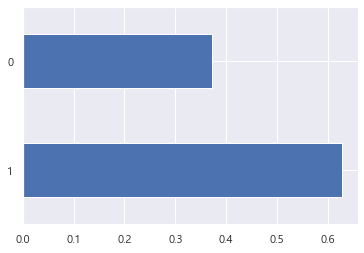

In [3]:
df['target'].value_counts(normalize=True).plot(kind='barh')

# Fit Model

In [4]:
# Set up the data for modelling 
y=df['target'].to_frame() # define Y
X=df[df.columns.difference(['target'])] # define X

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test

# build model - Xgboost
import xgboost as xgb
xgb_mod=xgb.XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel()) 

# make prediction and check model accuracy 
y_pred = xgb_mod.predict(X_test)

# Performance
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.37%


In [5]:
# Generate the Tree explainer and SHAP values
import shap
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

### instances의 shape value + expected_value가 음수이면 '0', 양수이면 '1'

In [6]:
data = pd.DataFrame(shap_values)
data['sum_shap'] = data.sum(1)
data['E[f(x)]_expected_value'] = expected_value
data['y_pred'] = xgb_mod.predict(X)
data['f(x)_prediction_shap'] = data['sum_shap'] + expected_value
data.sort_values('f(x)_prediction_shap')

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,sum_shap,E[f(x)]_expected_value,y_pred,f(x)_prediction_shap
260,-0.888225,-0.376908,0.152883,-0.026797,-0.016850,-0.324573,0.118279,-1.554329,-0.102148,-0.057986,...,0.0,-0.826161,-0.788057,-0.370204,-0.343528,-0.946712,-10.336410,1.103166,0,-9.233244
264,-0.719525,-0.426090,0.184494,-0.022400,-0.016595,-0.390879,0.118279,-1.695796,-0.102148,-0.057986,...,0.0,-0.765046,-0.930636,-0.343480,-0.474916,-0.633764,-10.231662,1.103166,0,-9.128496
85,-0.916175,-0.386185,-0.215945,-0.022054,0.015816,-0.372152,0.115417,-1.871765,-0.102148,-0.057986,...,0.0,-0.829062,-0.698474,-0.340589,-0.474274,-0.644710,-10.042784,1.103166,0,-8.939618
265,-0.925159,-0.416813,0.152883,-0.024481,-0.016850,-0.317106,0.118279,-1.522280,-0.102148,-0.057986,...,0.0,-0.751557,-0.827443,-0.287196,-0.166820,-0.912127,-10.022867,1.103166,0,-8.919702
6,-0.916175,-0.409404,0.184494,-0.022400,-0.006874,-0.390879,0.115417,-1.649508,-0.102148,-0.057986,...,0.0,-0.776614,-0.831997,-0.343787,-0.342887,-0.633764,-9.843637,1.103166,0,-8.740472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.847909,0.709920,0.162433,-0.019996,0.032991,0.202101,0.152326,0.951702,0.066314,0.014949,...,0.0,0.907975,0.433887,0.229812,0.231461,0.456643,8.293862,1.103166,1,9.397028
540,0.847909,0.620759,-0.233109,-0.016661,0.032991,0.202101,0.152326,0.931695,0.066314,0.015279,...,0.0,0.820101,0.372110,0.199212,0.450292,0.989646,8.363282,1.103166,1,9.466448
556,0.847909,0.595328,0.162433,0.019732,-0.003368,0.260519,0.152326,0.947388,0.066314,0.014949,...,0.0,0.907975,0.462534,0.198240,0.450292,0.784767,8.507564,1.103166,1,9.610729
304,0.806759,0.637866,0.162433,-0.019996,0.032991,0.202101,0.152748,0.954520,0.066314,0.014949,...,0.0,0.872287,0.400338,0.200456,0.434507,0.773915,8.996676,1.103166,1,10.099842


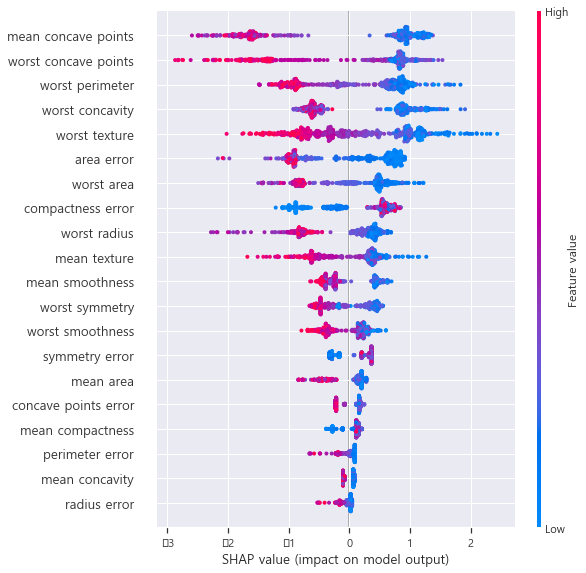

In [7]:
############## visualizations #############
# Generate summary dot plot
shap.summary_plot(shap_values, X,title="SHAP summary plot") 

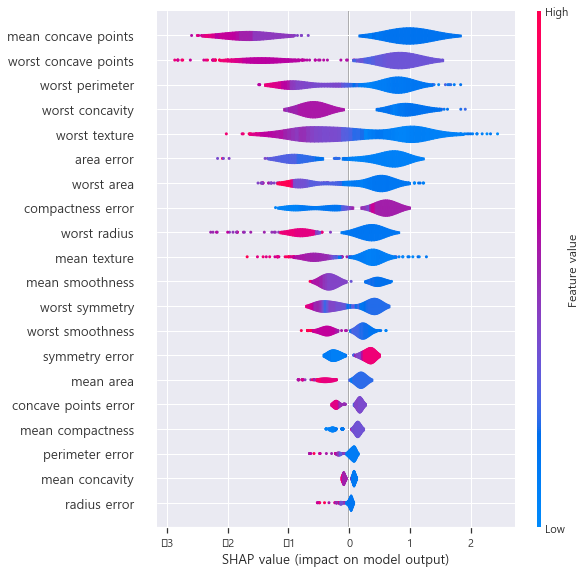

In [8]:
shap.summary_plot(shap_values, X, plot_type="violin", color='coolwarm')

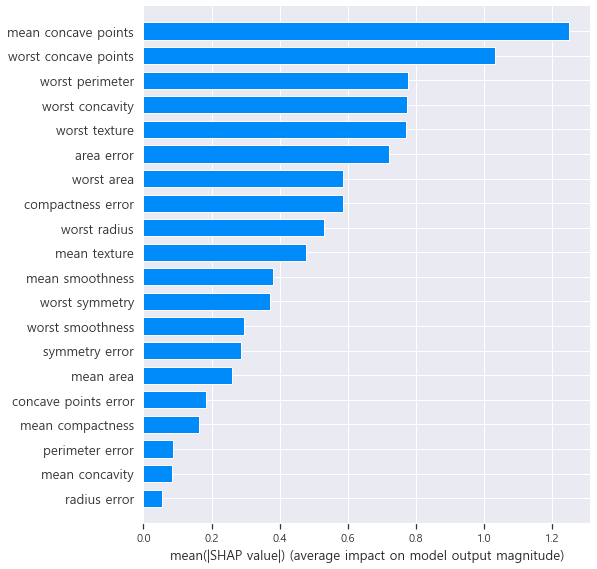

In [9]:
# Generate summary bar plot 
shap.summary_plot(shap_values, X,plot_type="bar") 

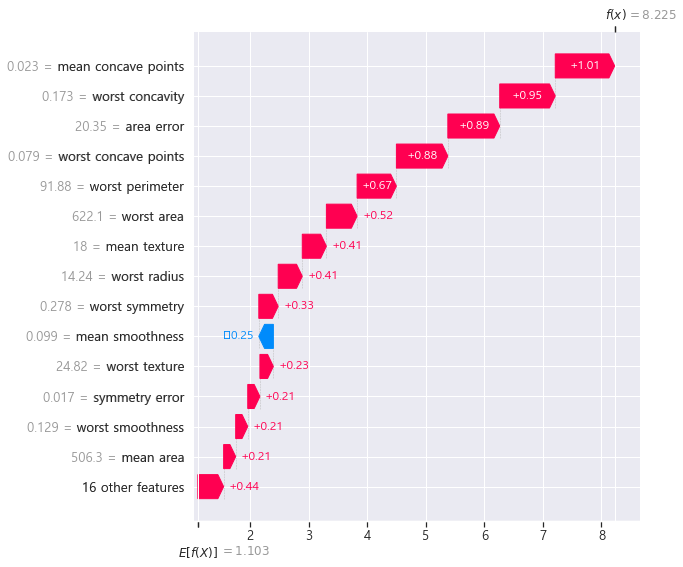

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,sum_shap,E[f(x)]_expected_value,y_pred,f(x)_prediction_shap
79,0.886357,-0.163758,0.162433,-0.019996,-0.003368,0.205968,0.152326,1.01498,0.066314,-0.020891,...,0.0,0.67147,0.411458,0.206146,0.331414,0.229657,7.121956,1.103166,1,8.225122


In [10]:
# Generate waterfall plot  
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[79], features=X.loc[79,:], feature_names=X.columns, max_display=15, show=True)
data[79:80]

In [11]:
# load JS visualization code to notebook
shap.initjs()

# Generate force plot - Single
shap.force_plot(explainer.expected_value, shap_values[79,:], X.iloc[79,:])

## Decesion plot
The x-axis represents the model’s output. In this case, the units are log odds. * The plot is centered on the x-axis at explainer.expected_value.

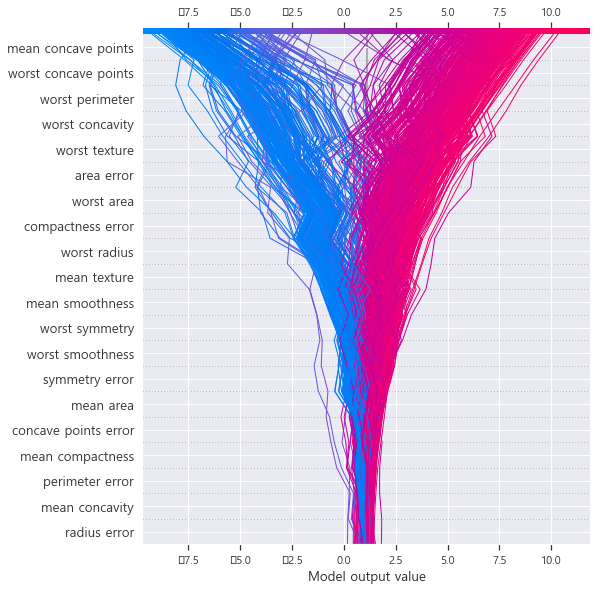

In [12]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html
shap.decision_plot(expected_value, shap_values, X.columns)

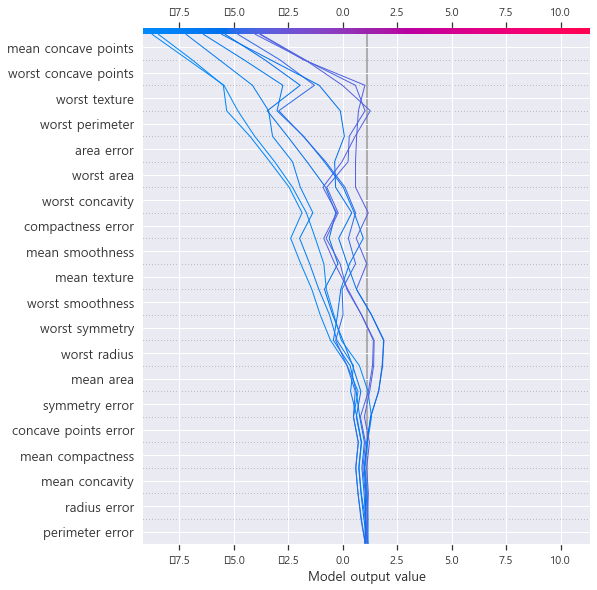

In [13]:
# Generate Decision plot 
shap.decision_plot(expected_value, shap_values[0:10], X.columns)

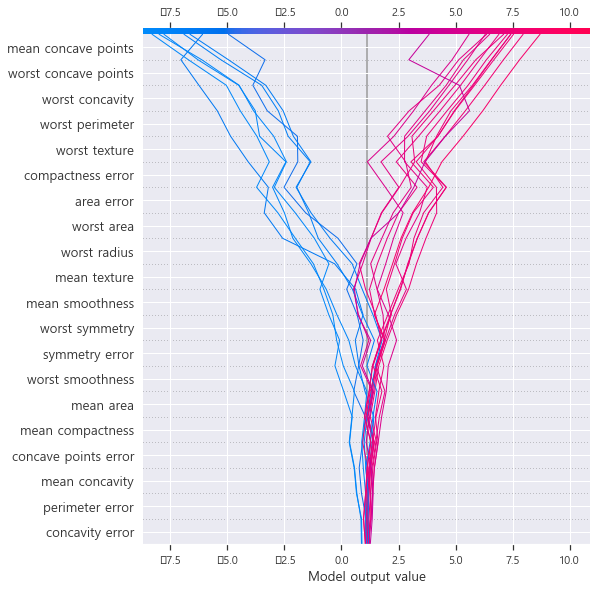

In [14]:
shap.decision_plot(expected_value, shap_values[50:70], X.columns)

In [15]:
# Generate force plot - Multiple rows 
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

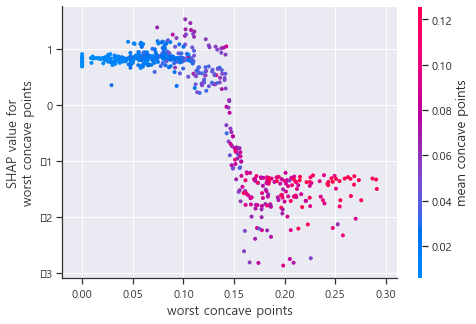

In [16]:
# Generate dependence plot
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

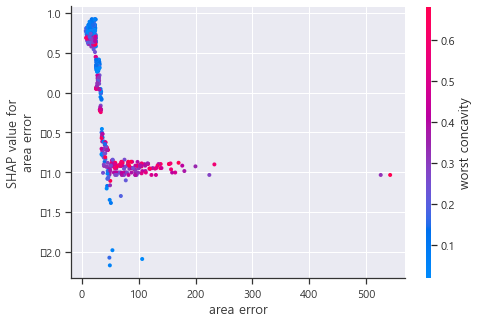

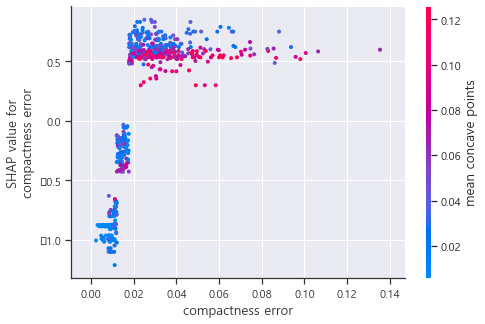

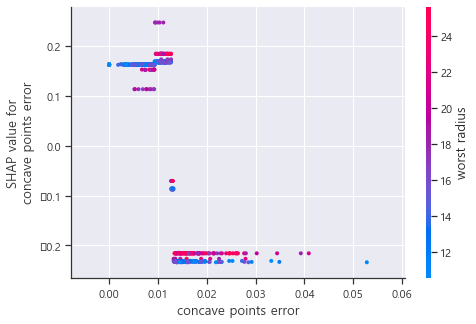

In [17]:
# Generate multiple dependence plots
for name in X_train.columns[0:3]:
     shap.dependence_plot(name, shap_values, X)

## 다른 형태로 shap values를 객체화하여 각종 plot을 그리기

In [18]:
import xgboost
import shap

# train XGBoost model
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X[:1000])

In [19]:
shap_values

.values =
array([[ 0.62169907, -0.43401289,  0.39875295, ..., -0.11033077,
        -0.09677086,  0.01857766],
       [ 1.13552066, -0.31867756,  0.59223477, ..., -0.18700682,
        -1.41011228,  0.01317442],
       [ 0.34425901, -0.01008124, -0.36671931, ..., -0.12711806,
         0.02860301, -0.01081819],
       ...,
       [ 1.49549124,  0.23508548,  0.63669679, ..., -0.06990894,
         1.41618169,  0.00727221],
       [ 0.74157083,  0.01715141, -0.02091197, ..., -0.15317868,
         0.08625329,  0.01086906],
       [ 0.56383731,  0.16433599,  0.60576817, ..., -0.08611892,
         0.63544979,  0.01867114]])

.base_values =
array([-2.68469186, -2.68469186, -2.68469186, -2.68469186, -2.68469186,
       -2.68469186, -2.68469186, -2.68469186, -2.68469186, -2.68469186,
       -2.68469186, -2.68469186, -2.68469186, -2.68469186, -2.68469186,
       -2.68469186, -2.68469186, -2.68469186, -2.68469186, -2.68469186,
       -2.68469186, -2.68469186, -2.68469186, -2.68469186, -2.68469186,
 

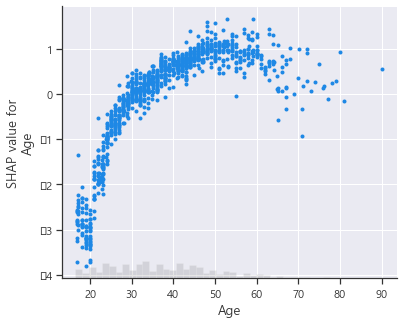

In [20]:
shap.plots.scatter(shap_values[:,"Age"])

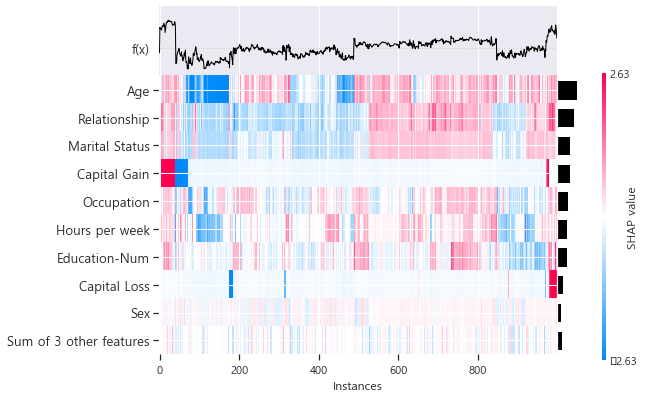

In [21]:
shap.plots.heatmap(shap_values)

## Deep learning

In [22]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


### 1.Loading the diabets dataset in Keras

In [23]:
dataset = pd.read_csv('../data/diabetes.csv')
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### 2. 데이터셋 생성하기

In [24]:
x_train = dataset.iloc[:700,0:8]
y_train = dataset.iloc[:700,8]
x_test = dataset.iloc[700:,0:8]
y_test = dataset.iloc[700:,8]

### 3. 모델 구성하기
- Multicalss Classification 
- 입력변수 8개를 받아 2개 hidden을 만들고 마지막 레이어는 sigmoid 활성화함수로 모델 구현

In [25]:
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### 4. 모델 학습과정 설정하기

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 5. 모델 학습시키기

In [27]:
model.fit(x_train, y_train, epochs=150, batch_size=64)

Epoch 1/150
700/700 [==============================] - 0s 341us/step - loss: 3.5177 - accuracy: 0.4886
Epoch 2/150
700/700 [==============================] - 0s 13us/step - loss: 2.7148 - accuracy: 0.4743
Epoch 3/150
700/700 [==============================] - 0s 13us/step - loss: 2.0134 - accuracy: 0.4586
Epoch 4/150
700/700 [==============================] - 0s 11us/step - loss: 1.5309 - accuracy: 0.4729
Epoch 5/150
700/700 [==============================] - 0s 13us/step - loss: 1.2252 - accuracy: 0.5329
Epoch 6/150
700/700 [==============================] - 0s 13us/step - loss: 1.0584 - accuracy: 0.5471
Epoch 7/150
700/700 [==============================] - 0s 11us/step - loss: 0.9861 - accuracy: 0.5400
Epoch 8/150
700/700 [==============================] - 0s 11us/step - loss: 0.9380 - accuracy: 0.5414
Epoch 9/150
700/700 [==============================] - 0s 11us/step - loss: 0.8881 - accuracy: 0.5443
Epoch 10/150
700/700 [==============================] - 0s 13us/step - loss: 0.83

700/700 [==============================] - 0s 11us/step - loss: 0.5715 - accuracy: 0.6843
Epoch 81/150
700/700 [==============================] - 0s 11us/step - loss: 0.5711 - accuracy: 0.6957
Epoch 82/150
700/700 [==============================] - 0s 13us/step - loss: 0.5702 - accuracy: 0.6914
Epoch 83/150
700/700 [==============================] - 0s 11us/step - loss: 0.5692 - accuracy: 0.7000
Epoch 84/150
700/700 [==============================] - 0s 11us/step - loss: 0.5700 - accuracy: 0.6971
Epoch 85/150
700/700 [==============================] - 0s 11us/step - loss: 0.5682 - accuracy: 0.6929
Epoch 86/150
700/700 [==============================] - 0s 11us/step - loss: 0.5678 - accuracy: 0.7043
Epoch 87/150
700/700 [==============================] - 0s 11us/step - loss: 0.5665 - accuracy: 0.7029
Epoch 88/150
700/700 [==============================] - 0s 11us/step - loss: 0.5676 - accuracy: 0.6986
Epoch 89/150
700/700 [==============================] - 0s 13us/step - loss: 0.5668 - 

In [31]:
import shap
shap.initjs()

In [36]:
explainer = shap.GradientExplainer(model, x_train.values)
shap_values = explainer.shap_values(x_test.values)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


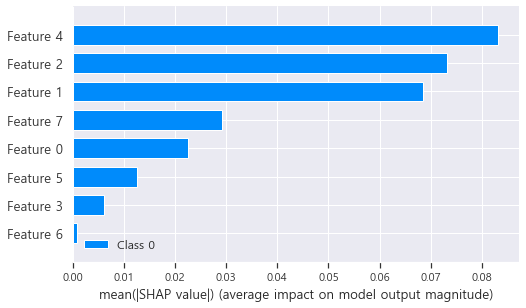

In [37]:
#shap_values = explainer.shap_values(x_test.values)
shap.summary_plot(shap_values, x_test.values)

## Keras LSTM for IMDB Sentiment Classification
https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20Keras.html
https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/deep_explainer/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html

In [46]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras.models import Model
from keras.layers.embeddings import Embedding
from tqdm import tqdm
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [47]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [48]:
# build model
input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss='binary_crossentropy')
regression.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k,t in dtypes], y_valid)
)

Train on 26048 samples, validate on 6513 samples
Epoch 1/50
26048/26048 [==============================] - 1s 27us/step - loss: 2.2941 - val_loss: 0.4618
Epoch 2/50
26048/26048 [==============================] - 0s 5us/step - loss: 0.4269 - val_loss: 0.3965
Epoch 3/50
26048/26048 [==============================] - 0s 5us/step - loss: 0.3925 - val_loss: 0.3819
Epoch 4/50
26048/26048 [==============================] - 0s 5us/step - loss: 0.3784 - val_loss: 0.3715
Epoch 5/50
26048/26048 [==============================] - 0s 5us/step - loss: 0.3707 - val_loss: 0.3731
Epoch 6/50
26048/26048 [==============================] - 0s 5us/step - loss: 0.3698 - val_loss: 0.3725
Epoch 7/50
26048/26048 [==============================] - 0s 6us/step - loss: 0.3760 - val_loss: 0.3907
Epoch 8/50
26048/26048 [==============================] - 0s 6us/step - loss: 0.3727 - val_loss: 0.3749
Epoch 9/50
26048/26048 [==============================] - 0s 5us/step - loss: 0.3592 - val_loss: 0.3792
Epoch 10/50
26

In [49]:
def f(X):
    return regression.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [50]:
explainer = shap.KernelExplainer(f, X.iloc[:50,:])
shap_values = explainer.shap_values(X.iloc[299,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])

In [51]:
shap_values50 = explainer.shap_values(X.iloc[280:330,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values50, X_display.iloc[280:330,:])

In [38]:
# Utilizing our same xgb_mod model object created above
############## load packages ############
# import packages
import pandas as pd
import numpy as np
import time 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
import shapash
import shap
import datatable as dt # data table factory
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from shapash.utils.load_smartpredictor import load_smartpredictor
from shapash.explainer.smart_explainer import SmartExplainer

ModuleNotFoundError: No module named 'shapash'

In [ ]:
############## launch the app #############
# create explainer
xpl = SmartExplainer()
xpl.compile(
    x=X_test,y
    
    model=xgb_mod
)
#Creating Application
app = xpl.run_app(title_story='Breast Cancer')

############## visualizations #############
# feature importance based on SHAP
xpl.plot.features_importance()

# contributions plot
xpl.plot.contribution_plot("worst concave points")

# Local explanation
xpl.plot.local_plot(index=79)

# compare plot 
xpl.plot.compare_plot(index=[X_test.index[79], X_test.index[80]])

# Interactive interactions widget 
xpl.plot.top_interactions_plot(nb_top_interactions=5)

# save contributions
predictor = xpl.to_smartpredictor()
predictor.add_input(x=X_train, ypred=y_train)
detailed_contributions = predictor.detail_contributions()

# End